<a href="https://colab.research.google.com/github/tarun1820/Mini_project/blob/main/matrix_factorisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**data looading and matrix factorisation function**


In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path


users=pd.read_csv("/content/drive/MyDrive/moviedata/users.csv",sep="\t")
users.head()

def matrix_factorization(D, k, lmbda, iterations):
    m, n = D.shape
    # Randomly initialize user and item latent vectors
    Pu = np.random.normal(scale=1./k, size=(m, k))
    Qv = np.random.normal(scale=1./k, size=(n, k))
    # Iteratively update user and item latent vectors until convergence
    for _ in range(iterations):
        for u in range(m):
            # Compute gradient and update user latent vector
            rating_indices = D[u, :] > 0
#             print(rating_indices)
            Qv_rating = Qv[rating_indices, :]#extracting the ratings with are rated by user
            D_rating = D[u, rating_indices]
            Pu[u, :] = np.linalg.solve(np.dot(Qv_rating.T, Qv_rating) + lmbda*np.eye(k), np.dot(Qv_rating.T, D_rating)) #np.linalg.solve(A,B) for (A^-1)*B
        for v in range(n):
            # Compute gradient and update item latent vector
            rating_indices = D[:, v] > 0
            Pu_rating = Pu[rating_indices, :]
            D_rating = D[rating_indices, v]
            Qv[v, :] = np.linalg.solve(np.dot(Pu_rating.T, Pu_rating) + lmbda*np.eye(k), np.dot(Pu_rating.T, D_rating))
    return Pu, Qv



In [ ]:
            # ****************----------------------------------------------------------------------------------------------------------*********************

# Load the ratings data
ratings = pd.read_csv('/content/drive/MyDrive/moviedata/ratings.csv',sep='\t')
ratings.to_csv('/content/drive/MyDrive/moviedata/ratings2.csv',sep=',',index=False)
# Group the ratings data by user ID
grouped_ratings = ratings.groupby('userId')

# Define a function to get a random sample of 20% of movies rated by a user
def get_sample(group):
    return group.sample(frac=0.2, random_state=np.random.seed())

# Apply the function to each group and concatenate the results
userid_ordered_data = grouped_ratings.apply(get_sample).reset_index(drop=True)

print(userid_ordered_data)


        userId  movieId  rating  timestamp  user_emb_id  movie_emb_id
0            1      608       4  978301398            0           607
1            1     1962       4  978301753            0          1961
2            1      938       4  978301752            0           937
3            1     3114       4  978302174            0          3113
4            1     1207       4  978300719            0          1206
...        ...      ...     ...        ...          ...           ...
200011    6040     3017       1  956716519         6039          3016
200012    6040     3083       4  963272132         6039          3082
200013    6040     1296       2  956715383         6039          1295
200014    6040     3342       3  956715910         6039          3341
200015    6040     3168       4  964828900         6039          3167

[200016 rows x 6 columns]


<h1 class="hi">Transforming tabular data to matrix format</h1>
<style>
.hi{
  "color":"red"
}
</style>

In [ ]:
base_matrix=userid_ordered_data.pivot(index="userId",columns="movieId",values="rating")

#storing coloum indesis
movie_index_from_basematrix=base_matrix.columns.values

nparray_theta_tidle=base_matrix.to_numpy()
print("shape of sample raitng data",nparray_theta_tidle.shape)
D_theta_tidle=np.nan_to_num(nparray_theta_tidle)
print(D_theta_tidle)

shape of sample raitng data (6040, 3462)
[[5. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


**code to generate latent features of users and movies**


In [ ]:
k = 10
lmbda = 0.1
iterations = 100
# Train the model on the training data
Pu_theta_tidle, Qv_theta_tidle = matrix_factorization(D_theta_tidle, k, lmbda, iterations)

In [13]:
print(Pu_theta_tidle.shape)
print(Qv_theta_tidle.shape)

(6040, 10)
(3462, 10)


In [17]:
from scipy.spatial.distance import pdist, squareform


def max_euclidian_distance(np_matrix):

    # Calculate pairwise distances using Euclidean distance
    pairwise_distances = pdist(np_matrix, metric='euclidean')

    # Convert pairwise distances to a square matrix
    distance_matrix = squareform(pairwise_distances)

    # Find the maximum distance (diameter)
    diameter = np.max(distance_matrix)

    return diameter

print("Diameter of the data points(D):", max_euclidian_distance(Pu_theta_tidle))


Diameter of the data points(D): 11.248524663643167


L2 Norms of Points: [ 3.74165739  8.77496439 13.92838828]


In [18]:
def compute_gradients(R, U, V):
    error_matrix = R - np.dot(U, V.T)
    num_observed = np.count_nonzero(~np.isnan(R))

    dU = -2 * np.dot(error_matrix, V) / num_observed
    dV = -2 * np.dot(error_matrix.T, U) / num_observed

    return dU, dV


dU, dV = compute_gradients(D_theta_tidle, Pu_theta_tidle, Qv_theta_tidle)

print(dU.shape)



(6040, 10)


In [19]:
l2_norms_of_gradient = np.linalg.norm(dU, axis=1)

print("L2 Norms of Points:", l2_norms_of_gradient)
print("g=",np.max(l2_norms_of_gradient))

L2 Norms of Points: [0.00098679 0.00103509 0.00101421 ... 0.00092673 0.00124164 0.00085117]
g= 0.0016640300789605418


In [ ]:
#saving the parameters
np.savetxt('/content/drive/MyDrive/moviedata/latent_user.csv', Pu_theta_tidle, delimiter=",")
np.savetxt('/content/drive/MyDrive/moviedata/latent_movie.csv', Qv_theta_tidle, delimiter=",")

**finding values of G and D?**

In [ ]:
import numpy as np
import pandas as pd
users=pd.read_csv("/content/drive/MyDrive/moviedata/ratings.csv",sep="\t")
users.head()

,userId,movieId,rating,timestamp,user_emb_id,movie_emb_id
0,1,1193,5,978300760,0,1192
1,1,661,3,978302109,0,660
2,1,914,3,978301968,0,913
3,1,3408,4,978300275,0,3407
4,1,2355,5,978824291,0,2354


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/moviedata/ratings.csv",sep="\t")


# print(df.groupby("userId").groups)
# grouped_by_userId=df.groupby("userId");
# filtered_data_frame=grouped_by_userId.filter(lambda x:x["movieId"].count()>20)
# grouped_by_movieId=filtered_data_frame.groupby("movieId");
# filtered_data_frame=grouped_by_movieId.filter(lambda x:x["userId"].count()>20)
pivoted_data=df.pivot(index="userId",columns="movieId",values="rating")
# col_list=list(pivoted_data.columns)
# print(col_list);

# movie index and movieid element list
movie_index=pivoted_data.columns.values
# print(movie_index)
nparray=pivoted_data.to_numpy()
print("shape of comple rating data",nparray.shape)
D=np.nan_to_num(nparray)
print(D)

shape of comple rating data (6040, 3706)
[[5. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [3. 0. 0. ... 0. 0. 0.]]


In [ ]:
def rmse_2D(X,Y):
  n=len(X)
  # print("x is ==",X)
  m=len(X[0])

  sum_squ=0
  denominator=0
  for i in range(n):
    for j in range(m):
      if X[i][j]!=0:
          sum_squ=sum_squ+(X[i][j]-Y[i][j])**2
          denominator+=1
  return sum_squ/denominator

def rmse_1D(X,Y):
  n=len(X)
  sum_squ=0
  denominator=0
  for i in range(n):
      if X[i]!=0:
          sum_squ=sum_squ+(X[i]-Y[i])**2
          denominator+=1
  return sum_squ/denominator

In [ ]:

k = 10
lmbda = 0.1
iterations = 100

# Train the model on the training data
Pu_theta_tidle, Qv_theta_tidle = matrix_factorization(D_theta_tidle, k, lmbda, iterations)

# Compute the predicted ratings for the test data

print(D_theta_tidle)
D_pred_theta_tidle = np.dot(Pu_theta_tidle, Qv_theta_tidle.T)

print(D_pred_theta_tidle)
rmse_theta_tidle = np.sqrt(rmse_2D(D_theta_tidle,D_pred_theta_tidle))
print(rmse_theta_tidle)


Pu, Qv = matrix_factorization(D, k, lmbda, iterations)

# Compute the predicted ratings for the test data
print(D)
D_pred= np.dot(Pu, Qv.T)

print(D_pred)
rmse = np.sqrt(rmse_2D(D,D_pred))
print(rmse)


[[5. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [3. 0. 0. ... 0. 0. 0.]]
[[ 4.95398844  4.94658052  2.25571723 ...  1.11857757  3.21245784
   4.87623331]
 [ 4.77120004  4.65424938  3.97724858 ...  2.1973751   3.11137675
   3.78909258]
 [ 4.34678693  4.26272434 -0.00985729 ...  5.95943125  0.88237352
   2.90727178]
 ...
 [ 3.30560386  3.05538773  4.97876234 ...  3.02962411  2.35126934
   1.81812611]
 [ 4.974188    3.62759417  3.18149544 ...  2.13910112  2.29738163
   3.76209089]
 [ 3.99743906  2.53997856  2.03929316 ...  2.90802366  3.37608935
   4.09866854]]
0.5554390031246732
[[5. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [3. 0. 0. ... 0. 0. 0.]]
[[4.17916585 3.80170016 4.31673926 ... 4.26574681 3.03514176 3.58629048]
 [4.4376726  3.52332644 3.20415251 ... 4.22971    3.70392042 4.02299625]
 [3.54484257 3.60510292 4.16266

In [ ]:
no_of_users=len(Pu)
feedback={
    "sum_loss_theta":np.array([.0 for user in range(no_of_users)]),
    "sum_loss_theta_tidle":np.array([.0 for user in range(no_of_users)])
    }

def loss_each(rating,user_latent,movie_latent):
  D_pred=np.dot(user_latent,movie_latent.T)
  loss=np.sqrt(rmse_1D(rating,D_pred))
  return loss


# projection function
def find_beta_t(r_t,z_t,theta):
  beta_t=[]
  for i in range(len(z_t)):
    # print(i)
    norm_dis=np.linalg.norm(z_t[i]-theta[i])
    # print(norm_dis)

    if norm_dis<=r_t[i]:
      beta_t.append(0)
    else:
      # print(r_t[i])
      beta_t.append(1-(r_t[i]/norm_dis))
  return beta_t

def projected_theta(beta_t,Pu_theta_tidle,Pu):
  # print(len(Pu))
  # print(len(Pu_theta_tidle))
  pro_theta=[None]*len(Pu)

  for i in range(len(Pu_theta_tidle)):
    single_pro=beta_t[i]*Pu_theta_tidle[i]+(1-beta_t[i])*Pu[i]
    # print(single_pro)
    pro_theta[i]=single_pro
  return pro_theta




2.8361225477002705
1.4180612738501353
0.9453741825660167
0.7090306369250676
0.5672245095400541
0.47268709128411857
0.4051603639565471
0.35451531846364404
0.3151247275212654
[3.097606719746038, 3.430788895253879, 3.5461553154224266, 3.6045309259175435, 3.6397651029070297, 3.663338772411933, 3.680217508673181, 3.6928983371158717, 3.7027739706616494]


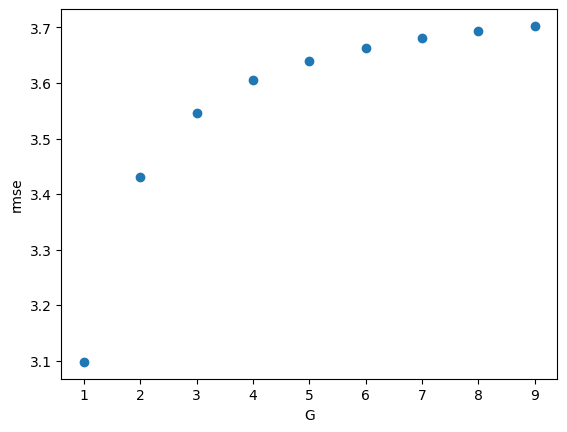

In [ ]:
no_of_users=len(Pu)
loss_t=np.array([loss_each(D[i],Pu[i],Qv) for i in range(no_of_users)])
loss_tidle=np.array([loss_each(D_theta_tidle[i],Pu_theta_tidle[i],Qv_theta_tidle) for i in range(no_of_users)])
feedback["sum_loss_theta"]+=loss_t
feedback["sum_loss_theta_tidle"]+=loss_tidle
Di=20000
G=12
e_l=1e-4
e_u=10
alpha=3


#radius for each user

# print(min((feedback["sum_loss_theta"]-(1+alpha)*feedback["sum_loss_theta_tidle"]-alpha*float(e_l))/(Di*G)))
g_list=[]
for i in range(1,10):
  g_list.append(i)
rmse_list=[]
for G in g_list:
    radius_fraction=1+((feedback["sum_loss_theta"]-(1+alpha)*feedback["sum_loss_theta_tidle"]-alpha*float(e_l))/(Di*G))
    # print(len(radius_fraction))
    rt=np.array([max(0,i) for i in radius_fraction])
    # print(rt)
    r_t=(1-rt)*Di
    print(max(r_t))
    # r_t=r_t.reshape(6040,1)
    # print(r_t)

    beta_t=find_beta_t(r_t,Pu_theta_tidle,Pu)
    # print(beta_t)
    # print(max(beta_t))


    theta_t=projected_theta(beta_t,Pu_theta_tidle,Pu)
    # print(theta_t)

    D_pred_project= np.dot(theta_t, Qv.T)
    # print("projected = ",D_pred_project[0])

    rmse = np.sqrt(rmse_2D(D,D_pred_project))
    # print(rmse)
    rmse_list.append(rmse)

    D_pred= np.dot(Pu, Qv.T)

    # print("original latent=",D_pred[0])
    rmse = np.sqrt(rmse_2D(D,D_pred))
    # print(rmse)
print(rmse_list)
import matplotlib.pyplot as plt
plt.scatter(g_list, rmse_list)
plt.xlabel("G")
plt.ylabel("rmse")
plt.show()


In [ ]:
!pip install gower
import gower
gower.gower_matrix(users)
users.loc[len(users.index)] = [6040,6041,"M",25,10,12233,"25-34","other or not specified"]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


UFuncTypeError: ignored

In [ ]:


indx=6041
depend_users=gower.gower_topn(users.iloc[indx-1:,:], users.iloc[:,], n = 10)
similar=depend_users['index']
print(similar)
print(Pu)
print(len(Pu))
a=[]
for i in range(1,len(similar)):
  a.append(Pu[similar[i]])
print(a)
newuserPu=[]
for i in range(0,len(a[0])):
  c=0
  for j in range(0,len(a)):
    c=c+a[j][i]
  c=c/len(a)
  newuserPu.append(c)
Pu=Pu.tolist()
Pu.append(newuserPu)
Pu=np.array(Pu)
print(newuserPu)
print(Pu)

[6040 6022 6018 5895 5835 5815 5813 5787 5769 5747]
[[-4.71708622  0.08603111  0.89216644 ... -0.96905341 -0.4934448
  -0.01319759]
 [-4.16440194  0.09685381  1.61262538 ... -0.09037793 -0.16596969
  -0.11734659]
 [-4.584814    0.46436838  0.24219965 ...  0.40352423  0.06621578
   0.21614679]
 ...
 [-3.94004876  0.04592633  1.18100352 ...  0.09716273 -0.53980189
  -0.7759658 ]
 [-2.73134503  0.54768004  1.07120138 ...  1.10748544 -1.63644225
  -0.64377028]
 [-3.95700993  0.07624527  0.34486623 ... -0.15519414 -0.37805335
  -0.55026922]]
6041
[array([-4.13745855,  0.86247358,  1.31973444, -0.34865479,  2.25526865,
        0.85878454, -0.13136483, -0.54542066,  0.39473791, -0.68110204]), array([-4.35988998,  0.17008443,  0.44817897,  0.03152999,  2.37009212,
        0.93569877, -0.80579425, -0.41556515, -0.76465183, -0.26540779]), array([-2.9861965 , -1.03287034,  0.14981231, -0.0325778 ,  2.61946403,
       -0.05097951,  0.87585405, -0.7249649 , -0.8100404 , -1.09900623]), array([-4.244

In [ ]:

feedback={
    "loss_t":0,
    "loss_tilda":0
}
D=2000**0.5
G=1200**0.5
e_l=1e-4
e_u=10
Lt=0
Lt_tilda=0
alpha=0.1
user=pd.read_csv("C:/Users/Dell/Desktop/moviedata/users.csv",sep="\t")
ratings=pd.read_csv("C:/Users/Dell/Desktop/moviedata/ratings.csv",sep="\t")
movies=pd.read_csv("C:/Users/Dell/Desktop/moviedata/ratings.csv",sep="\t")
def find_theta_tilda(userId):
    [reformed_data,column_names]=reform(users,ratings,True,userId)
    Pu,Qv=matrix_factorization(reformed_data,10,0.1,100)
    feedback['theta_tilda']=Pu
    D_pred = np.dot(Pu, Qv.T)
    pred_rating={}
    for i in range(0,len(column_names)):
        pred_rating[column_names[i]]=D_pred[0][i]
    print(pred_rating)
def find_zt(userId):
    [reformed_data,colum_name]=reformed(users,ratings,False,userId)
    latent=matrix_factorization(reformed_data,10,0.1,100)
    feedback['zt']=latent
    Pu=latent[0][userId-1]
    Qv=latent[1]
    D_pred = np.dot(Pu, Qv.T)
    print(D_pred )
    rmse = np.sqrt(np.mean((D_pred - D)**2))
    feedback['current']=rmse
def find_actual(userId):
    t=t+1
    find_zt(userId)
    find_theta_tilda(userId)
    theta_tilda=feedback["theta_tilda"]
    feedback['gloos_t-1']=(1-beta)*feedback["loss_t-1"]
    z_t=feedback["z_t"]
    beta=updatebeta(feedback)
    prediction={}
    x_t1=beta*z_t+beta*(1-theta_tilda)
    prediction["z_t"]=x_t1
    prediction["beta"]=beta
    return prediction
def updatebeta(feedback):
    Lt+=feedback["loss_t-1"]
    Lt_tilda+=feedback["loss_def_t-1"]
    bdgt=(1+alpha)*Lt_tilda-Lt
    rt=(1-max(0,((-bdgt-alpha*el)/(D*G))+1))*D
    dis=np.linalg.norm(feedback['zt']- feedback["theta_tilda"])
    if dis>=rt:
        beta=(1-(rt/dis))
    else:
        beta=0
    feedback['loss_t-1']=feedback['current']
    return beta

FileNotFoundError: ignored

In [ ]:
#grove find dissimilarities between users w.r.t the age,gendex and location(Zipcode).we are taking only top 5 similar users
!pip install gower
import gower
#new user is added to useres data frame
users.loc[len(users.index)] = [6040,6041,"M",25,10,12233,"25-34","other or not specified"]
print(users)
indx=users.shape[0]
refrence_for_new_users=gower.gower_topn(users.iloc[indx-1:,:], users.iloc[:,], n = 6)

#taking similar 5 users latent vectors and averaging them for finding new user theta_tidal
new_users_without_him=refrence_for_new_users['index'][1:]
new_user_latentvecors=np.zeros(10)
for x in new_users_without_him:
  print(Pu[x])
  new_user_latentvecors=new_user_latentvecors+ Pu[x]
new_user_latentvecors=new_user_latentvecors/len(new_users_without_him)
print(new_user_latentvecors)
new_ratings=np.dot(new_user_latentvecors,Qv.T)
print(len(new_ratings))


#recomadaing top5 movies to new users with movieid
top_5ratings=sorted(range(len(new_ratings)), key=lambda i: new_ratings[i],reverse=True)[0:5]
print(top_5ratings)
recomend_new_movies=[]
for i in top_5ratings:
  recomend_new_movies.append(movie_index[i])
print(recomend_new_movies)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#new user gives rating to old movie
indx=users.shape[0]
print(indx)
existing_user_rating=[6040,45,3.0]
[user_id,movie_id,rating]=existing_user_rating
#adding to rating vector
# D[existing_user_rating[0]-1][]
x,=np.where(movie_index==movie_id)
print(x)
print( D[user_id-1,x[0]])
if x.size>0:
  D[user_id-1,x[0]]=rating






6041
[44]


TypeError: ignored

In [ ]:
def reform(users,ratings,new_users):
    if new_users==True:
        dis=gower.gower_matrix(users)
        depend_users=gower.gower_topn(users.iloc[indx-1:,:], users.iloc[:,], n = 10)
        depend_users=depend_users['index'][1:]
        res=users.iloc[depend_users]
        ratings.set_index('userId',inplace=True)
        df=ratings.loc[depend_users]
        ratings.to_csv("rat.csv")
        dfs=pd.read_csv("rat.csv")
    else:
        dfs=ratings
    pivoted_data=dfs.pivot(index="userId",columns="movieId",values="rating")
    column_name=list(pivoted_data.columns.values)
    # col_list=list(pivoted_data.columns)
    # print(col_list);
    nparray=pivoted_data.to_numpy()
    print(nparray.shape)
    D=np.nan_to_num(nparray)
    return [D,column_name]